# NASA Star Classification

The goal of this notebook is to complete a basic project including exploration, cleaning, visualization, and classification. The dataset used here is the [Star Type Classification / NASA](https://www.kaggle.com/brsdincer/star-type-classification) dataset on Kaggle. Its target value is the "Type" feature, and 6 other features are given for classification.

## Import Data

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('C:/Users/kcmas/Documents/Datasets/Stars/Stars.csv')

In [3]:
types = ['Red Dwarf', 'Brown Dwarf', 'White Dwarf', 'Main Sequence', 'Super Giants', 'Hyper Giants']

## Data Exploration

In [4]:
data.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0


In [5]:
data.describe()

,Temperature,L,R,A_M,Type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


In [6]:
data.isnull().sum()

Temperature       0
L                 0
R                 0
A_M               0
Color             0
Spectral_Class    0
Type              0
dtype: int64

## Cleaning and Feature Engineering

In [7]:
import numpy as np

In [8]:
data.columns = [c.lower() for c in data.columns]

In [9]:
log_cols = ['temperature', 'l', 'r']

In [10]:
for c in log_cols:
    data[c+'_log'] = np.log10(data[c])

In [11]:
data['color'] = data['color'].str.replace('-', ' ').str.replace('ish','').str.replace('Pale ','').str.title()
data['color'] = data['color'].replace('Whit', 'White')
data['color'] = data['color'].replace('White Yellow', 'Yellow White')

In [12]:
data['color'].unique()

array(['Red', 'Blue White', 'White', 'Yellow White', 'Yellow Orange',
       'Blue', 'Orange', 'Yellow', 'Orange Red'], dtype=object)

In [13]:
color_order = ['Red', 'Orange Red', 'Orange', 'Yellow Orange', 'Yellow','Yellow White','White','Blue White', 'Blue']

In [14]:
data['color_value'] = data['color'].apply(lambda x: color_order.index(x))

In [15]:
data['spectral_class_value'] = data['spectral_class'].apply(lambda x: list(data['spectral_class'].unique()).index(x))

## Basic Visualizations

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

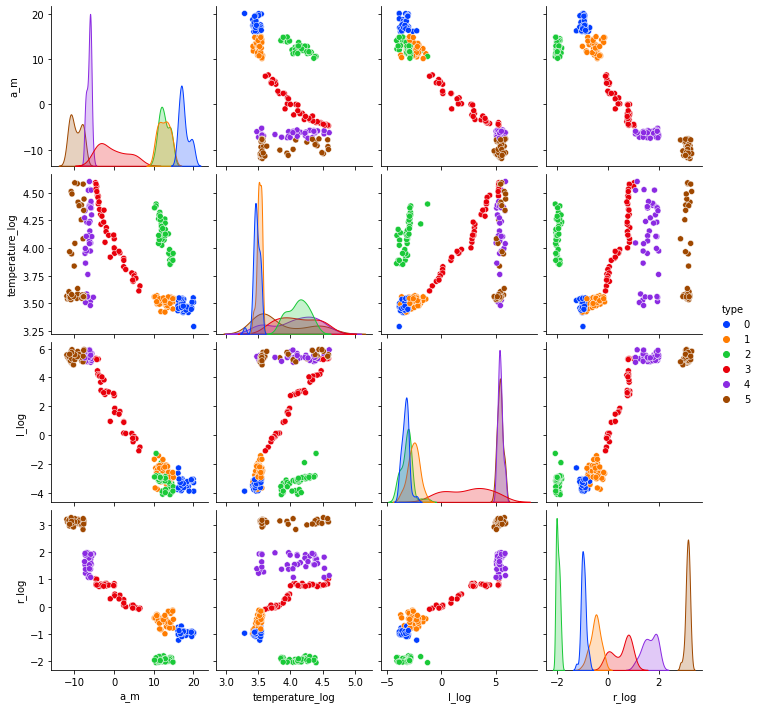

In [17]:
drop_cols = log_cols.copy()
drop_cols.extend(['color_value', 'spectral_class_value']) # I currently don't want to see categorical data
sns.pairplot(data.drop(drop_cols, axis=1), hue='type', palette='bright')

In [18]:
# Ideally these are linearly correlated
fig = px.scatter(data, x='a_m', y='l_log', trendline='ols', title='Linear Regression', width=900, height=600)
corr = np.corrcoef(data['a_m'], data['l_log'])[0][1]

fig.show()
print(f'Correlation: {corr}')

Correlation: -0.9765787172720571


## Advanced Visualizations

In [19]:
from IPython.display import Image

### H-R Classification Chart

In [20]:
# This will help fix the color distribution in the chart
data['color_value_adj'] = np.power(data['color_value'], 2)

In [21]:
# Let's try to re-create the H-R classification chart
fig = px.scatter(
    data,
    x = 'temperature',
    y = 'a_m',
    log_x = True,
    #log_y = True,
    color = 'color_value_adj',
    size = data['r_log'] - data['r_log'].min() + .15,
    color_continuous_scale = 'RdYlBu',
    template = 'plotly_dark',
    labels = {
        'l': 'Relative Luminosity (Sun=1)',
        'temperature': 'Surface Temperature (K)',
        'a_m': 'Absolute Magnitude'
    }
)

fig.update_layout(
    title = 'H-R Star Classification Chart',
    coloraxis_showscale = False,
    width = 1200,
    height = 800
)

'''
fig.add_annotation(
    x = 3.763428,
    y = -0.09151489,
    xshift = -30,
    yshift = -15,
    text = 'The Sun',
    showarrow = False
)
'''
fig.add_annotation(
    x = 3.763428,
    y = 5.05,
    xshift = -30,
    yshift = -15,
    text = 'The Sun',
    showarrow = False
)

fig.update_xaxes(autorange='reversed')
fig.update_yaxes(autorange='reversed')

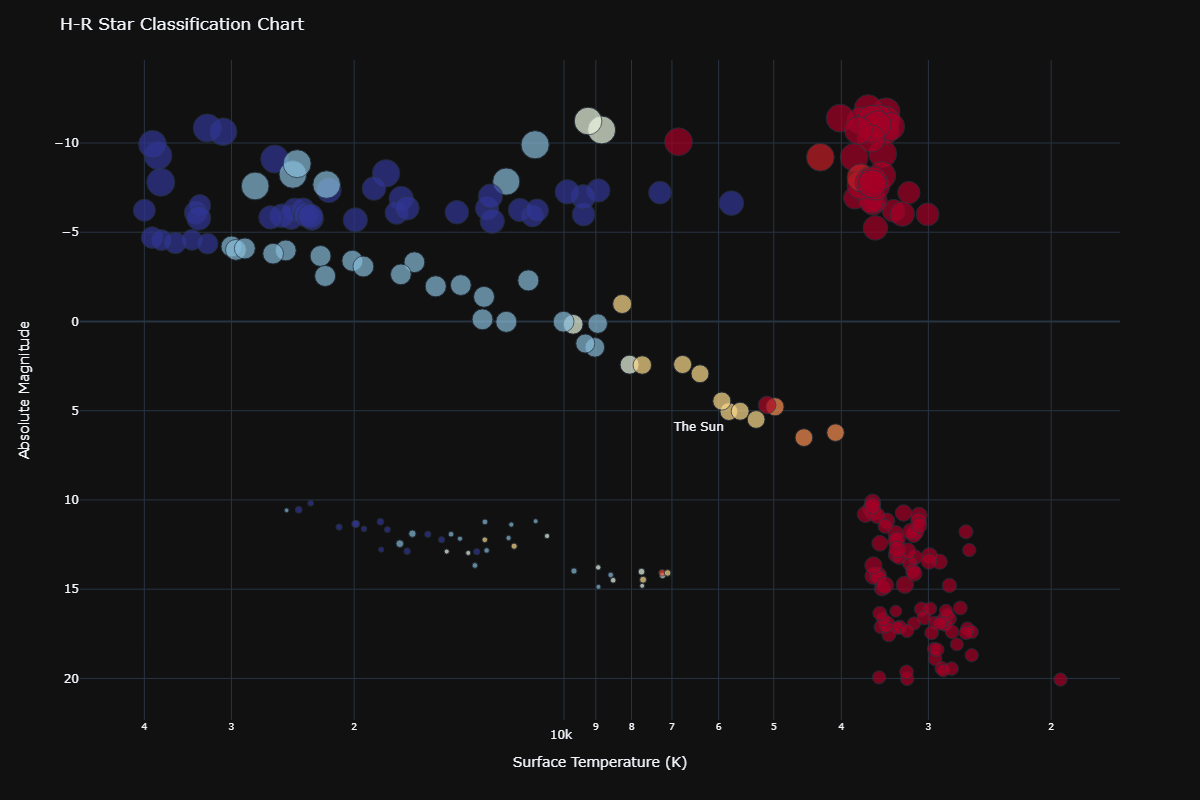

In [22]:
# Static image for GitHub notebook viewing
Image(fig.to_image('png'))

## KNN Classification

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler


In [24]:
X = data[['temperature_log', 'l_log', 'r_log', 'color_value', 'spectral_class_value']]
y = data['type']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [26]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [28]:
predictions = knn.predict(X_test)

## Model Evaluation

In [29]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [30]:
accuracy = accuracy_score(y_test, predictions)

print(f'Accuracy: {accuracy}')

Accuracy: 0.8958333333333334


In [31]:
scores = cross_val_score(knn, X, y, cv=5)

print(f'Cross Validation Average Score: {scores.mean()}')

Cross Validation Average Score: 0.9083333333333334
